# Fitbit Project 

#### Goals:

1. Predict final two weeks of fitbit data

2. Write a notebook containing our analysis

3. Create a function to make a tidy csv of the fitbit data

4. Summarize the data

5. Present the information to a general audience

### Planning
Pipeline:
    
   1. ***Acquire*** - Create a python function that will make a csv containing all the activity data from the fitbit. The function will find the activity data in each csv, pull it from there and write it to a fresh csv. Then, make a dataframe of that data.
   2. ***Prep*** - Remove all commas from numeric data. Ensure numeric data is stored as a numeric data type, and convert date from string to datetime. Rename columns to accomodate laziness and/or be more descriptive. Set the index of the dataframe to the date and sort the dataframe by date.
   3. ***Explore*** - Read up on how the fitbit collects data and other meaningful fitness metrics like the basal metabolic rate and stride-height conversion rate. Using this information, calculate interesting data about the fitbit user such as height, weight, and conduct a rough hypothesis of their age range. Show visualizations and distributions of the various data.
   4. ***Model*** - Create predictive models for each feature using Prophet. Evaluate each with Prophet's performance metrics and write the final two weeks' predictions to a separate csv.

### Acquire

In [13]:
import warnings
warnings.filterwarnings("ignore")
from acquire import get_activity
from prepare import prep_activity, prep_for_prophet
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()

In [14]:
activity = get_activity()

### Prepare

In [15]:
activity = prep_activity(activity)

#### Data Dictionary:


steps - number of steps taken, tracked by a 3-axis accelerometer worn on the wrist. This sensor tracks the frequency, duration, intensity, and patterns of one's movement. Numbers can appear artificially lower if walking with arms still, such as when pushing a stroller. Numbers can appear artificially higher if sensor is jarred during inactivity, such as when riding down a bumpy road.

distance – distance in miles traveled that day, calculated by multiplying steps and stride length. Stride length is a constant value determined by an individual’s height and weight. If an activity is tracked, distance is calculated using GPS.

floors – floors traveled measured by an altimeter, which is a sensor that calculates altitude based on atmospheric pressure. The device is designed to detect pressure changes based on elevation gain, but other types of pressure changes, such as a gust of wind, a weather change, or opening a door can occasionally cause your device to register extra floors.

zones – fitbit tracks the heartrate of the subject and records the amount of time the subject spends in defined heartrate ranges, known as fitness zones. These zones correspond to the activity features presented in the date and have been renamed: out, fat_burn, cardio, and peak for brevity.  Each zone is described below in greater detail.

“out of zone” – time in minutes spent in “out of zone” below 50% of maximum heart rate. not considered exercise.

“fat burn zone” –  time in minutes spent in “fat burn zone” between 50% and 69% of maximum heart rate. Low to medium intensity workout.

“cardio zone” – time, in minutes, spent in “cardio zone” between 70% and 84% of maximum heart rate. Medium to high intensity workout. 

“peak zone” – time, in minutes, spent in “peak zone” greater than 85% of maximum heart rate. Intended for short durations of intense exercise. 

active_burned – number of calories fitbit estimates the subject had burned during exercise. Exact method of calculation is unknown, but uses heart rate.

total_burned – total number of calories burned during that day. Calculated using basal metabolic rate (the rate at which the subject burns calories at rest) and your activity data to estimate your calories burned.

BMR – number of calories burned per day at rest. calculated by subtracting active_burn from total_burned

Time – total time, in minuets, that fitbit was recording. The calculated sum of out, fat_burn, cardio, and peak columns.

Stride – The length the subject travels in one step, represented in feet. This is calculated by dividing distance (converted to feet) by steps.

min_age – Lowest age that produced a reasonable weight when calculated using the revised Harris-Benedict equation for Basal Metabolic Rate (BMR). Value is in years.

max_age – We chose to limit the scope of this part of the investigation to five years greater than the minimum age. Value is in years.

min_weight – approximate minimum weight of subject calculated using the revised Harris-Benedict equation for Basal Metabolic Rate (BMR). Value is in pounds.

max_weight - approximate maximum weight of subject calculated using the revised Harris-Benedict equation for Basal Metabolic Rate (BMR). Value is in pounds.

#### Appendix
The Revised Harris-Benedict Equation calculates BMR using the following formula for men:

BMR = 88.362 + (13.397 x weight in kg) + (4.799 x height in cm) - (5.677 x age in years)

Applications of this formula round decimal values to the nearest tenth. 

Fitbit calculates heart rate by emitting a green rapidly flashing light and using light-sensitive photodiodes to measure the change in light that is caused by capillaries in your arm expanding and contracting as your heart beats.

In [26]:
activity.describe().T

,count,mean,std,min,25%,50%,75%,max
total_burned,225.0,3401.911111,632.426578,799.000000,3069.000000,3385.000000,3765.000000,5199.000000
steps,225.0,8536.186667,5255.746608,0.000000,4714.000000,7806.000000,12380.000000,25512.000000
distance,225.0,4.046800,2.506253,0.000000,2.220000,3.680000,5.900000,12.000000
floors,225.0,12.591111,25.844174,0.000000,2.000000,7.000000,13.000000,195.000000
out,225.0,809.520000,243.232639,28.000000,654.000000,750.000000,877.000000,1440.000000
fat_burn,225.0,188.235556,75.170001,0.000000,158.000000,203.000000,236.000000,349.000000
cardio,225.0,14.920000,15.363535,0.000000,3.000000,11.000000,21.000000,78.000000
peak,225.0,33.871111,37.195986,0.000000,2.000000,15.000000,63.000000,154.000000
active_burned,225.0,1484.546667,747.795790,0.000000,1062.000000,1481.000000,1962.000000,3596.000000
bmr,225.0,1917.364444,192.377351,748.000000,1792.000000,1923.000000,2055.000000,2291.000000


### Explore

#### Mixed-up Labels

It is recommended that healthy adults get at least 150 minutes of moderate aerobic activity or 75 minutes of vigorous aerobic activity per week. This translates to roughly 21 minutes of moderate activity per day or 11 minutes of vigorous activity per day.

Based on this we would expect the amount of the subject's cardio time to exceed the amount of his peak time.

However, the subject's mean peak time is 34 minutes and his mean cardio time is only 15 minutes.

Additionally, according to the fitbit website the “cardio zone” should be the target zone for most people for a majority of their exercise. The “peak zone” is intended for intense workouts over a short duration.

Looking at the plot of the two columns in the subsequent graph one can see that these labels seem to be swapped.

For these reasons and because the man in the white coat mentioned he had mixed up some labels, we believe that the cardio and peak columns have been swapped with one another.

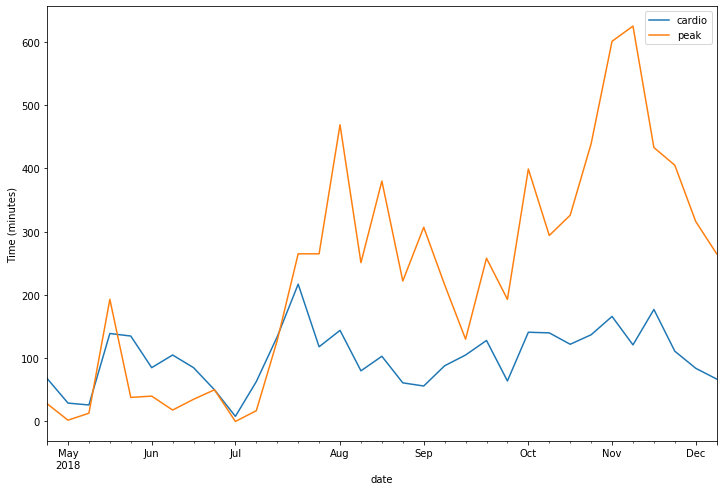

In [24]:
activity[['cardio', 'peak']].resample('W').sum().plot(figsize=(12,8))
plt.ylabel('Time (minutes)')
plt.show()

#### Gender

The average daily number of calories burned by gender is:

1600-2400 for females 

2000-3000 for males

The main determining factor of the number of calories an individual burns within each gender is their level of activity. The more activity a person has the more calories they will burn.

The subject wearing the fitbit has a mean calories burned of 2145 on the days when it was “out of zone” all day.

Comparing this number of calories burned with the range of average calories burned by male and female humans, we can infer that the subject is either a male with low activity or a female with moderate activity. 

Because this data was taken while the subject was “out of zone” for the full day we can conclude that the subject is likely to be male.

In [27]:
activity[(activity.out > 0) & (activity.fat_burn==0) & (activity.cardio==0) & (activity.peak==0)]

,total_burned,steps,distance,floors,out,fat_burn,cardio,peak,active_burned,bmr,time,stride,height,min_age,max_age,min_weight,max_weight
date,,,,,,,,,,,,,,,,,
2018-06-06,2145,0,0.0,0,1440,0,0,0,0,2145,1440,NaN,NaN,27,32,233.706172,238.395103
2018-06-07,2146,0,0.0,0,1440,0,0,0,0,2146,1440,NaN,NaN,27,32,233.870696,238.559627
2018-06-11,2146,0,0.0,0,1440,0,0,0,0,2146,1440,NaN,NaN,27,32,233.870696,238.559627
2018-06-26,2144,0,0.0,0,1440,0,0,0,0,2144,1440,NaN,NaN,27,32,233.541649,238.230579
2018-06-27,2145,0,0.0,0,1440,0,0,0,0,2145,1440,NaN,NaN,27,32,233.706172,238.395103
2018-06-28,2145,0,0.0,0,1440,0,0,0,0,2145,1440,NaN,NaN,27,32,233.706172,238.395103
2018-06-30,2145,0,0.0,0,1440,0,0,0,0,2145,1440,NaN,NaN,27,32,233.706172,238.395103
2018-07-03,2144,0,0.0,0,1440,0,0,0,0,2144,1440,NaN,NaN,27,32,233.541649,238.230579
2018-07-06,2144,0,0.0,0,1440,0,0,0,0,2144,1440,NaN,NaN,27,32,233.541649,238.230579


#### Height

Fitbit calculates a subject's distance by multiplying their steps by their stride length as follows:

Number of steps * stride  = distance

Stride can be computed using the following formula:

Stride = distance / steps

Stride = height * (.415) for men

Because we know the subject's step counts and their corresponding distances, we are able to calculate the subject's approximate stride length. Using the stride length we are then able to calculate the subject’s likely height.

In [29]:
activity.stride.median()

2.490181443829623

In [28]:
activity.height.median()

6.000437214047285

#### Weight

The weight computations are more involved.

Initially, we entered our known quantities (height and gender) into an online [BMR calculator](https://bmi-calories.com/bmr-calculator.html). Then, we supposed a minimum weight a fairly athletic six-foot man could reasonably maintain. We ballpark estimated this to be 155lbs. Given these data, we found the minimum age at which they could achieve our lowest reasonable BMR 